Who has the best home court advantage in college basketball? Duke? Kansas? Gonzaga? This can make for a fun bar conversation, mostly because you can make an argument for so many of the top teams. These arguments are typically qualitative - "Duke's student section is the best in the country" or "Allen Fieldhouse is insanely loud. I mean seriously, *insanely loud*." Since I have the box score data from every regular season college basketball game in the past seven years I'm going to take a more statistical approach.

To start, let's try to quantify how many points playing at home is actually worth. As usual, we start with the standard imports.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

Next we define a quick helper function to make it easier to import the data, which is stored in a separate file for each year, then pull each year's data into a separate frame, and finally concatenate them all

In [3]:
# a helper function to facilitate loading multiple csv files
def get_data(filename, columns=None):
    df = pd.read_csv(filename, sep=',', encoding='latin-1', \
                     skipinitialspace=True, index_col=1, usecols=columns)
    return df

# load the data from the last 7 college basketball seasons
filenames = [str(yr)+'_game_scores.csv' for yr in range(2009,2016)]
frames  = [get_data('data/'+f) for f in filenames]

# index the full dataframe by the filename where the raw data came from
data_full = pd.concat(frames, keys=filenames)

Now for some actual analysis: for each Divison I team let's go through and find the difference in average points per game (ppg) for home and away games. The raw data does contain some non-Division I teams, so we have to be careful to avoid including them or we'll skew our results (lower tier teams are much more likely to play away from home, and much more likely to get blown out. Taken together these two facts could make away games seem worse than they actually are.) We'll generate a list of every team that shows up in the data, and then filter out those that only show up a few times.

In [4]:
# get the names of every team that has a home game in the data
names_full = data_full.groupby('home_name').count().game_ID

# filter out teams with less than 10 home games in the whole dataset
# these will be non-Division I teams
team_list = names_full[names_full>10].index

In [5]:
# we'll fill this with a bunch of dictionaries containing {name, away, home, diff}
ppg_avgs = []

# process each year separately
for f in filenames:
    
    # pull the year off the front of the filename
    year = f[:4]
    
    for team in team_list:
        away_games = data_full.ix[f]['away_name'] == team
        home_games = data_full.ix[f]['home_name'] == team
    
        # compute avg points per game, for home and away games
        away_ppg = data_full.ix[f]['away_final'][away_games].mean()
        home_ppg = data_full.ix[f]['home_final'][home_games].mean()
        
        # compute avg points allowed per game, home and away
        away_papg = data_full.ix[f]['home_final'][away_games].mean()
        home_papg = data_full.ix[f]['away_final'][home_games].mean()
        
        diff_ppg = home_ppg - away_ppg
        diff_papg = home_papg - away_papg
        
        entry = {'year':year, 'team':team, \
                 'away_ppg':away_ppg, 'home_ppg':home_ppg, 'diff_ppg':diff_ppg, \
                 'away_papg':away_papg, 'home_papg':home_papg, 'diff_papg':diff_papg}
        ppg_avgs.append(entry)
        
ppg = pd.DataFrame(ppg_avgs)

# rearrange columns, just for convenience
ppg = ppg[['year', 'team', 'away_ppg', 'home_ppg', 'diff_ppg', \
           'away_papg', 'home_papg', 'diff_papg']].dropna()

Let's take a quick look at the distribution of (home points per game ) - (away points per game).

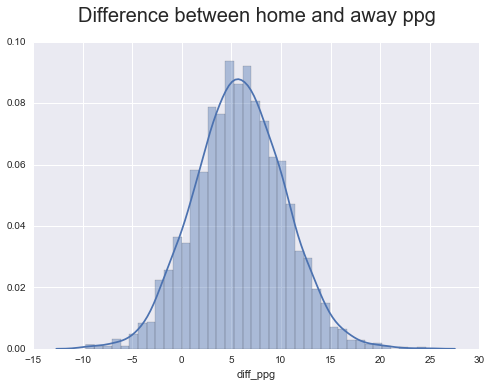

In [6]:
sns.distplot(ppg['diff_ppg']);
plt.title('Difference between home and away ppg', fontsize=20, y=1.05);

In [7]:
print('Mean  : ' , ppg.describe()['diff_ppg']['mean'])
print('StdDev: ' , ppg.describe()['diff_ppg']['std'])

Mean  :  5.8327450862
StdDev:  4.52692408694


At first glance it looks like home court advantage is worth about 5.8 \\(\pm\\) 4.5 points. However, we're actually 'double counting' the advantage. If we make the simplifying assumption that home court advantage is the same for all teams and arenas (which it certainly isn't, but it should work to first order), then we can say
\\[
\text{home score} = \text{neutral score} + \Delta \\\\
\text{away score} = \text{neutral score} - \Delta
\\]
then
\\[
\text{home score} - \text{away score} = 2 \Delta
\\]

The real situation is obviously more complicated than this, but even with our simple analysis we get a home court advantage of 3 \\(\pm\\) 2.3 points, which is pretty close to the consensus of 'around four points' 
[link](http://www.boydsbets.com/college-basketball-home-court-advantage/)
[link](http://www.madduxsports.com/library/cbb/putting-a-value-on-home-court-advantage-in-college-basketball.html)
[link](http://www.predictionmachine.com/college-basketball-homecourt-advantage).

This is pretty neat aggregate result, but we haven't said anything about the advantage conferred by any individual arena yet. One possible approach is to see which teams have the largest spread between home and away ppg, and attribute that to the advantage of the home court. However, there are a lot of factors besides the advantage of the arena itself that can contribute to a team having better stats at home than on the road. For example, high caliber programs often play a lot of lower-tier teams at the beginning of the season to tune things up a bit. These types of games are almost always played at the higher-tier team's home court, which inflates the home statistics of some teams and deflates the away statistics of other teams.

Let's check if measuring which teams score more points at home than away is a good proxy for the advantage conferred by the team's home arena. If it is, then an ordered list of teams, ranked by how much better they are at home than away, should be somewhat consistent year to year. If the rankings aren't particularly correlated from year to year then this is probably not a good way to measure home court advantage.

In [10]:
# rearrange the data so that it's indexed by team name, and each year's
# diff is in it's own column
pivoted_ppg = ppg.dropna().pivot(index='team', columns='year', values='diff_ppg')
pivoted_papg = ppg.dropna().pivot(index='team', columns='year', values='diff_papg')

# rank each school's diff_ppg and diff_papg, for each year
ranked_ppg = pivoted_ppg.apply(scipy.stats.rankdata, axis=0)
ranked_papg = pivoted_papg.apply(scipy.stats.rankdata, axis=0)

# add column with the average ranking
ranked_ppg['mean'] = ranked_ppg.mean(axis=1)

print(ranked_ppg.sort(columns='mean').head(5))

year              2009  2010  2011  2012  2013  2014   2015       mean
team                                                                  
Quinnipiac          30   180     6     2     8     3   10.0  34.142857
St Francis (BKN)     3    20   117    74    19    12   57.0  43.142857
Rider               43    14    23   172     3    25   40.5  45.785714
LBSU                47   151    33     6    41    28   58.0  52.000000
Manhattan            7    50    80    17    92    14  118.0  54.000000


Not looking too good so far - when I think 'intimidating home court' the first name that springs to mind is definitely not Quinnipiac. Let's go ahead and plot a heatmap showing the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the rankings for each year. We'll also plot a scatterplot with the rankings from two different years so we can get a more visual sense of the correlation. 

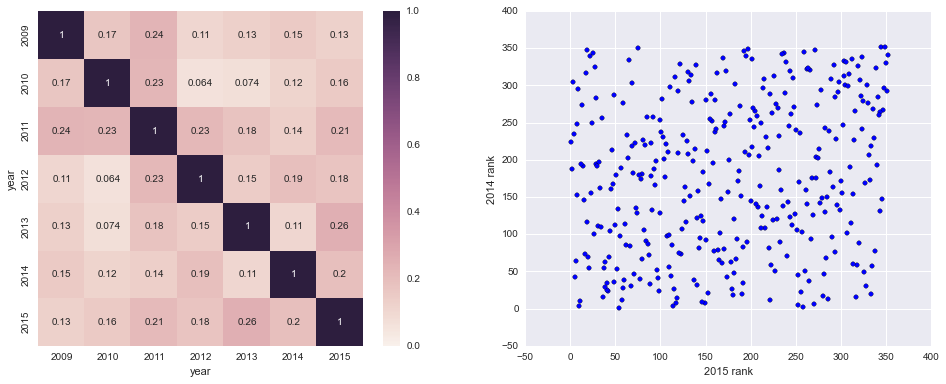

In [13]:
# helper function to make plots
def make_plots(df, hmap_ax, scat_ax, year1='2015', year2='2014'):
    # plot a correlation matrix of the yearly rankings
    sns.heatmap(df.corr(method='spearman'), annot=True, ax=hmap_ax, vmin=0, vmax=1)

    # plot (year1 rank) vs (year2 rank) for each team
    xs = scipy.stats.rankdata(df[year1].values)
    ys = scipy.stats.rankdata(df[year2].values)
    scat_ax.scatter(xs,ys);
    scat_ax.set_xlabel(year1 + ' rank');
    scat_ax.set_ylabel(year2 + ' rank');


fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,6))
make_plots(pivoted_ppg, ax1, ax2)

Definitely not very correlated. Looks like measuring which teams perform better at home than away does not give very consistent results year to year, so it's probably not a good proxy for the advantage conferred by indivdual arenas.

Time for a new plan: let's compare how visiting teams do at each arena to how they did on average in away games. If, at a given court, the visiting teams score 10 points fewer than they do on average in away games, that might be a better indicator of the actual advantage of the home court. We can do this for both offense and defense, i.e. we can compare visiting points per game and visiting points allowed per game to away averages.

In [12]:
# we'll use this to look up the avg away ppg and papg for each team
grouped_ppg = ppg.groupby(['year','team']).first()

# we'll fill this with a bunch of dictionaries containing {name, away, home, diff}
diffs = []

# helper function to get difference in ppg or papg
def get_diff(opp, year, get='ppg'):
    
    assert get in ['ppg','papg']
    opp_games = data_full.ix[f]['away_name'] == opp
        
    if get == 'ppg':            
        # note: may return more than one value if the teams played more than once
        opp_this = data_full.ix[f][home_games & opp_games]['away_final'].values
        opp_avg = grouped_ppg.ix[year,opp]['away_ppg']
                
    elif get == 'papg':
        # note: may return more than one value if the teams played more than once
        opp_this = data_full.ix[f][home_games & opp_games]['home_final'].values
        opp_avg = grouped_ppg.ix[year,opp]['away_papg']
        
    d = opp_this - opp_avg
                
    # note: if d has two entries the second entry almost certainly
    # refers to a game played at a neutral site. Teams never play
    # each other twice at one team's home court
    return d.tolist()[0]


# process each year separately
for f in filenames:
    
    # pull the year off the front of the filename
    year = f[:4]
    
    for team in team_list:
        home_games = data_full.ix[f]['home_name'] == team
        home_opponents = data_full.ix[f]['away_name'][home_games].values
        
        def_diffs = []
        off_diffs = []
        
        # for each opponent, take the difference of season average
        # ppg / papg (away games) and the points scored / allowed against this team
        for opp in set(home_opponents):
            try:
                def_diffs.append(get_diff(opp, year, 'ppg'))
                off_diffs.append(get_diff(opp, year, 'papg'))
            
            # for named non-DI schools that show up in the opponents list
            except KeyError:
                pass

        entry = {'year':year, 'team':team, \
                 'def_adv':np.mean(def_diffs),'off_adv':np.mean(off_diffs)}
        diffs.append(entry)
 
# the advantage column gives the factor by which the opposing teams score is 
# adjusted by playing here, i.e. -8 means teams score 8 fewer points on average
# at this arena
hca = pd.DataFrame(diffs)

/home/jhenri/anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


As before, we'll plot a correlation matrix comparing all the years, and a scatter plot comparing two of the years. We'll do this for both visiting team points per game and points allowed per game.

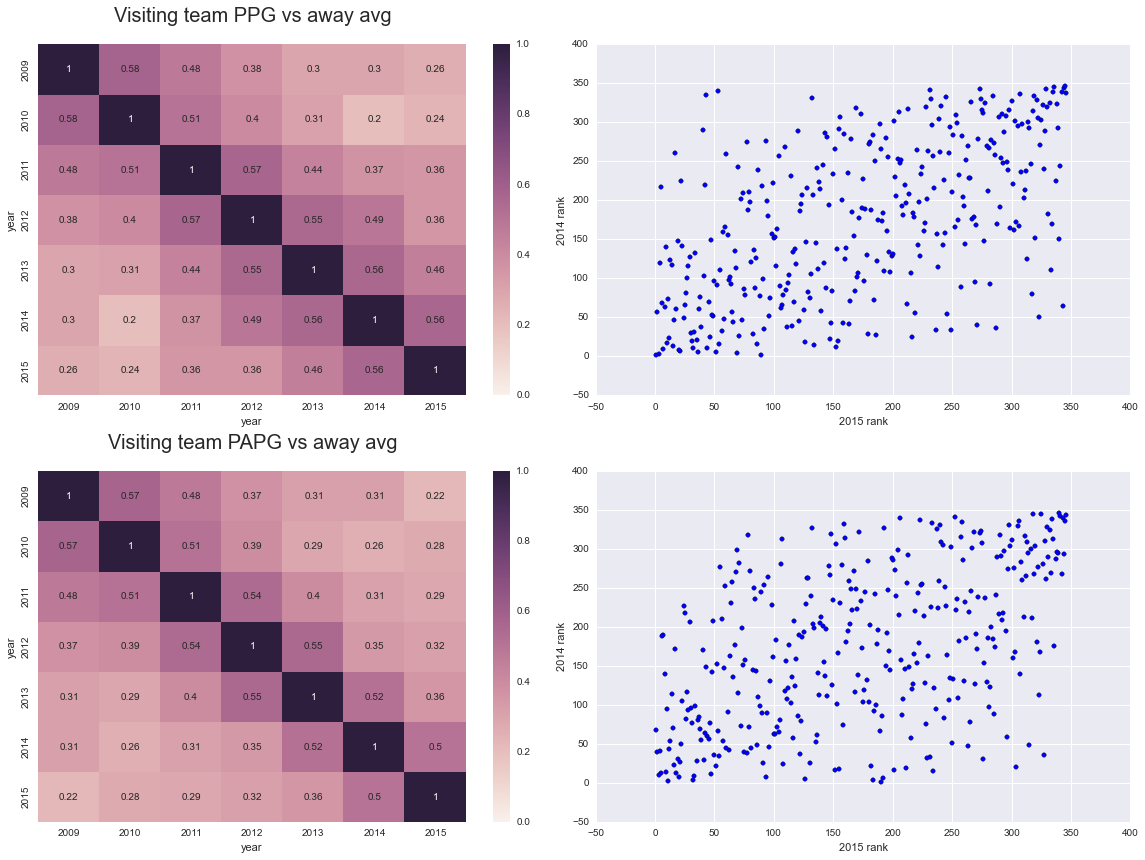

In [15]:
pivoted_hca_ppg = hca.pivot(index='team', columns='year', values='def_adv').dropna()
pivoted_hca_papg = hca.pivot(index='team', columns='year', values='off_adv').dropna()

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(16,12));

ax1.set_title('Visiting team PPG vs away avg', fontsize=20, y = 1.05);
ax3.set_title('Visiting team PAPG vs away avg', fontsize=20, y = 1.05);

make_plots(pivoted_hca_ppg, ax1, ax2)
make_plots(pivoted_hca_papg, ax3, ax4)

fig.tight_layout()

Alright, that's quite a bit better than the first attempt! However, home team quality is a pretty big confounding variable here - take the 2015 Kentucky team for example. Kentucky was unanimously considered the most talented team in the country in 2015, so it stands to reason that visiting teams both scored fewer points and allowed more points than their average when visiting Kentucky, just because they were playing Kentucky. This doesn't really speak to Kentucky's home court advantage, just the quality of the team.

To mitigate the effect of this confounding variable, let's combine the information from each factor we've considered so far (PPG and PAPG vs away averages, for both the home and visiting teams). Dominant teams shouldn't be too affected by their opponents' play, so differences in PPG / PAPG between their home and away games are more likely to reflect a home court advantage. Likewise, weaker teams shouldn't affect their opponents' play too much, so differences in visiting team PPG / PAPG are also more likely to reflect a real home court advantage.

We'll combine the rankings in each category by taking a simple average.

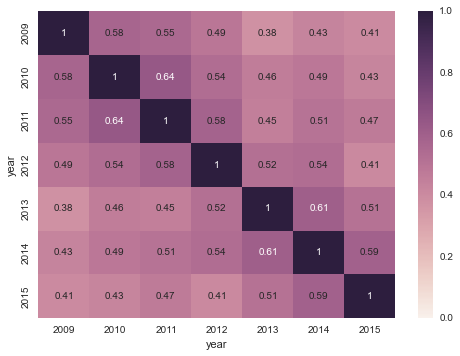

In [16]:
# rank the effect on home team PPG/PAPG for each year
ranked_ppg = pivoted_ppg.apply(scipy.stats.rankdata, axis=0)
ranked_papg = pivoted_papg.apply(scipy.stats.rankdata, axis=0)

# rank the effect on visiting PPG/PAPG for each year
ranked_hca_ppg = pivoted_hca_ppg.apply(scipy.stats.rankdata, axis=0)
ranked_hca_papg = pivoted_hca_papg.apply(scipy.stats.rankdata, axis=0)

# reverse the ordering of the PAPG stats, since 'good' values are 
# the opposite sign as 'good' PPG stats
ranked_hca_papg = ranked_hca_papg.apply(lambda col: (1 + len(col)) - col, axis=0)
ranked_papg = ranked_papg.apply(lambda col: (1 + len(col)) - col, axis=0)

# put all the rankings into the same dataframe,
# note: will result in duplicate column names
all_ranks = pd.concat((ranked_hca_papg, ranked_hca_ppg, ranked_ppg, ranked_papg), axis=1)

# group over the duplicate column names, i.e compute average 
# of the four rankings for each year
avg_ranks = all_ranks.groupby(level=0, axis=1).mean()

sns.heatmap(avg_ranks.corr(method='spearman'), annot=True, vmin=0, vmax=1);

Not too bad! It's especially encouraging that the correlation seems to reach a somewhat steady state after a few years. I'm inclined to take this as evidence that we're actually measuring a (mostly) static property of the arena, and not the temporary effect of a particularly good team one year.

To recap, we calculated, for each team, four different metrics that might reflect home court advantage:

- the difference between the team's average PPG at home and on the road
- the difference between the team's average PAPG at home and on the road
- the difference between visiting teams' average away PPG and their PPG at this team's home court
- the difference between visiting teams' average away PAPG and their PAPG at this team's home court

For each season, we ranked each team according to each of these metrics and then averaged the four rankings. This gave us a ranking of each school's home court advantage. Finally, we looked at the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the ranked lists for each pair of seasons, which is what is plotted above. The rankings are moderately correlated year to year, even after six years which implies that we're seeing something that persists on that time scale. Team quality fluctuates quite a bit over six years, so I'd say we captured at least some information about the real home court advantage.

No analysis of home court advantage would be complete without listing the Top-N, so here are the 15 best home courts according to our model:

In [17]:
# average the rankings accross all seasons
final_list = pd.DataFrame(avg_ranks.mean(axis=1))

# rank the teams 
final_list['rank'] = scipy.stats.rankdata(final_list)

# cue the debate
print(final_list.sort('rank')['rank'].head(15))

VCU                1
Louisville         2
Michigan State     3
Georgetown         4
Gonzaga            5
Villanova          6
Wichita State      7
Temple             8
Syracuse           9
Kansas            10
Kentucky          11
Pitt              12
BYU               13
UNLV              14
Wisconsin         15
Name: rank, dtype: float64


And in case you were wondering, Cornell comes in at [161](http://cornellsun.com/blog/2005/02/27/big-red-ambition-161-things-every-cornellian-should-do/) (no joke).